## Notes on reproducibility

Note that you may be getting different results with the same set of parameters since the initial state is random

In [1]:
import sys
import numpy as np
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

MEDIUM_SIZE = 12
# BIGGER_SIZE = 12

rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels

import matplotlib.pyplot as plt

sys.path.append('../code')
from utils import get_fashion_mnist_dataset, compute_additional_fields

## First, load results that reproduce Huang et al.

In [2]:
import pickle
import pandas as pd
from itertools import chain
from pathlib import Path
import qiskit_machine_learning
from tqdm import tqdm
tqdm.pandas()

recompute = False

if recompute:
    all_res = []

    for fname in Path("../data/results/reproduce_huang_et_al/").glob("reproduce_huang_et_al_*.p"):
        try:
            res = pickle.load(open(fname,'rb'))
        except (AttributeError, EOFError, TypeError) as e:
            print(e)
            print(fname)
            continue
        res.update(vars(res['args']))
        all_res.append(res)

    df_all = pd.DataFrame(all_res, columns=all_res[0].keys())
    df_all = compute_additional_fields(df_all, 'fashion-mnist', dumb_CV=True)
    df_all.drop(columns=['qkern_matrix_train', 'qkern_matrix_test'], inplace=True)
    pickle.dump(df_all, open('../data/results/reproduce_huang_et_al/aggregated.pkl', 'wb'))
else:
    df_all = pickle.load(open('../data/results/reproduce_huang_et_al/aggregated.pkl', 'rb'))

In [3]:
df_all['Number of qubits'] = df_all['dataset_dim'] + 1

In [4]:
df_all.describe()

,score,K_train_time,K_test_time,dataset_dim,n_trotter,init_state_seed,evo_time_factor,test_score,train_score,n_support_ave,C,norm(qkern_matrix_train - identity),Number of qubits
count,440.000000,440.000000,440.000000,440.000000,440.0,440.000000,4.400000e+02,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,0.556398,1872.471961,1753.327884,14.500000,20.0,10.500000,3.330000e-01,0.570843,0.998260,365.067045,75.622727,42.934468,15.500000
std,0.085319,2626.639614,2047.572217,6.351511,0.0,5.772845,5.557434e-17,0.071021,0.010680,66.135160,236.350871,68.160036,6.351511
min,0.450000,179.699763,209.276437,4.000000,20.0,1.000000,3.330000e-01,0.473319,0.896178,153.500000,1.000000,0.126943,5.000000
25%,0.475000,471.109151,567.868370,9.000000,20.0,5.750000,3.330000e-01,0.505238,1.000000,371.750000,1.000000,2.205776,10.000000
50%,0.530000,791.649521,978.288195,14.500000,20.0,10.500000,3.330000e-01,0.550648,1.000000,400.000000,1.000000,11.082596,15.500000
75%,0.621250,1821.763705,1818.915924,20.000000,20.0,15.250000,3.330000e-01,0.625879,1.000000,400.000000,4.000000,48.946322,21.000000
max,0.760000,12659.254578,12147.946243,25.000000,20.0,20.000000,3.330000e-01,0.767712,1.000000,400.000000,1024.000000,378.057000,26.000000


## Second, load results with optimal bandwidth

In [5]:
import copy

def aggregate_pickles(all_pickles_paths, dataset_name):
    all_res = []
    
    for fname in all_pickles_paths:
        try:
            res = pickle.load(open(fname,'rb'))
        except (AttributeError, EOFError, TypeError) as e:
            print(e)
            print(fname)
            continue
        res.update(vars(res['args']))
        all_res.append(res)

    df_all = pd.DataFrame(all_res, columns=all_res[0].keys())
    df_all = compute_additional_fields(df_all, dataset_name=dataset_name)
    df_all.drop(columns=['qkern_matrix_train', 'qkern_matrix_test'], inplace=True)
    return df_all
    
dfs = {}

folders = [
    ("../data/results/reproduce_with_optimal_bandwidth/", "fashion-mnist"),
]

for folder, dataset_name in folders:
    label = Path(folder).stem
    if "IQP" in folder:
        prefix = "IQP"
    else:
        prefix = "dim"
    all_pickles_paths = list(Path(folder).glob(f"{prefix}*.p"))
    npickles = len(all_pickles_paths)
    # check if the data in the pickles has been aggregated before
    # if not, compute an aggregated pickle with all the extra pickles
    must_reaggregate = True
    path_aggregated = Path(folder, "aggregated.p")
    if path_aggregated.exists():
        aggregated_df = pickle.load(open(path_aggregated, "rb"))
        if len(aggregated_df) == npickles:
            must_reaggregate = False
            print(f"For {folder}, using aggregated pickle from {path_aggregated}")
            dfs[label] = copy.deepcopy(aggregated_df)
    if must_reaggregate:
        aggregated_df = aggregate_pickles(all_pickles_paths, dataset_name)
        dfs[label] = copy.deepcopy(aggregated_df)
        print(f"For {folder}, saving aggregated pickle in {path_aggregated}")
        pickle.dump(aggregated_df, open(path_aggregated, "wb"))
    
df_fixed = dfs['reproduce_with_optimal_bandwidth']

df_fixed = df_fixed[(df_fixed['evo_time'] == 0.05) & (df_fixed['n_trotter'] == 20)]

For ../data/results/reproduce_with_optimal_bandwidth/, using aggregated pickle from ../data/results/reproduce_with_optimal_bandwidth/aggregated.p


In [6]:
df_fixed['Number of qubits'] = df_fixed['dataset_dim'] + 1

In [7]:
for dim in set(df_all['Number of qubits']):
    print(f"Num entries for nqubits={dim}: {sum(df_fixed['Number of qubits'] == dim)}")

Num entries for nqubits=5: 20
Num entries for nqubits=6: 20
Num entries for nqubits=7: 20
Num entries for nqubits=8: 20
Num entries for nqubits=9: 20
Num entries for nqubits=10: 20
Num entries for nqubits=11: 20
Num entries for nqubits=12: 20
Num entries for nqubits=13: 20
Num entries for nqubits=14: 20
Num entries for nqubits=15: 20
Num entries for nqubits=16: 20
Num entries for nqubits=17: 20
Num entries for nqubits=18: 20
Num entries for nqubits=19: 20
Num entries for nqubits=20: 20
Num entries for nqubits=21: 20
Num entries for nqubits=22: 20
Num entries for nqubits=23: 20
Num entries for nqubits=24: 20
Num entries for nqubits=25: 20
Num entries for nqubits=26: 20


In [8]:
df_fixed.describe()

,score,K_train_time,K_test_time,dataset_dim,n_trotter,evo_time,init_state_seed,shots,test_score,train_score,n_support_ave,C,norm(qkern_matrix_train - identity),Number of qubits
count,440.000000,440.000000,440.000000,440.000000,440.0,440.00,440.000000,440.0,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,0.877159,1773.611970,1594.805052,14.500000,20.0,0.05,10.500000,1.0,0.910125,0.942731,89.490909,151.250000,653.394301,15.500000
std,0.024795,2884.831630,2041.182609,6.351511,0.0,0.00,5.772845,0.0,0.018643,0.014911,12.226783,238.476278,32.783691,6.351511
min,0.765000,205.435160,233.482061,4.000000,20.0,0.05,1.000000,1.0,0.865390,0.901378,71.000000,2.000000,597.346612,5.000000
25%,0.870000,473.121460,569.654309,9.000000,20.0,0.05,5.750000,1.0,0.896945,0.933208,79.875000,16.000000,626.008879,10.000000
50%,0.880000,830.849606,1013.442348,14.500000,20.0,0.05,10.500000,1.0,0.912371,0.942794,86.500000,64.000000,650.246975,15.500000
75%,0.890000,1303.831376,1500.616726,20.000000,20.0,0.05,15.250000,1.0,0.924982,0.954417,97.500000,128.000000,676.687075,21.000000
max,0.910000,13196.268982,10426.810309,25.000000,20.0,0.05,20.000000,1.0,0.955834,0.980890,136.000000,1024.000000,746.728374,26.000000


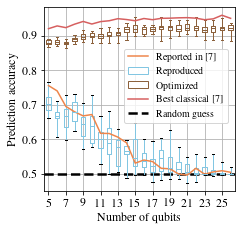

In [9]:
from matplotlib.patches import Patch
import seaborn as sns

f, ax = plt.subplots(figsize=(2*6.92654/4, 2*6.92654/4))

bp_fixed = df_fixed.boxplot(
    'test_score', 
    by='Number of qubits', 
    ax=ax, 
    whis=(0,100), 
    return_type='dict',
)

df_all_to_plot = df_all[df_all['Number of qubits'] <= df_fixed['Number of qubits'].max()]

bp = df_all_to_plot.boxplot(
    'test_score', 
    by='Number of qubits', 
    ax=ax, 
    whis=(0,100), 
    return_type='dict',
)

# lp = ax.plot(
#     range(1, len(set(df_all_to_plot['dataset_dim']))+1),
#     [1-x for x in [0.3045, 0.32, 0.332, 0.328, 0.3825, 0.383, 0.3935, 0.41, 0.469, 0.46, 0.4645, 0.484, 0.4855, 0.5005, 0.5035, 0.484, 0.501, 0.4945, 0.491, 0.4955, 0.4975, 0.4971]], 
#     label='Reported in [123]',
#     c=sns.color_palette("muted")[1]
# )

lp = ax.plot(
    range(1, len(set(df_all_to_plot['Number of qubits']))+1),
    [1-x for x in [0.244, 0.2595, 0.3045, 0.32, 0.332, 0.328, 0.3825, 0.383, 0.3935, 0.41, 0.469, 0.46, 0.4645, 0.484, 0.4855, 0.5005, 0.5035, 0.484, 0.501, 0.4945, 0.491, 0.4955]], 
    label='Reported in [7]',
    c=sns.color_palette("muted")[1]
)

lp_cl = ax.plot(
    range(1, len(set(df_all_to_plot['Number of qubits']))+1),
    [1-x for x in [0.079, 0.071, 0.076, 0.066, 0.058, 0.0655, 0.0585, 0.056, 0.05, 0.0525, 0.056, 0.0495, 0.053, 0.049, 0.0485, 0.0475, 0.047, 0.0485, 0.053, 0.0505, 0.04, 0.049]], 
    label='Best classical [7]',
    c=sns.color_palette("muted")[3]
)

for line in bp['test_score']['boxes']+bp['test_score']['whiskers']+bp['test_score']['medians']:
    line.set_color(sns.color_palette("muted")[9])
    
for line in bp_fixed['test_score']['boxes']+bp_fixed['test_score']['whiskers']+bp_fixed['test_score']['medians']+bp_fixed['test_score']['means']+bp_fixed['test_score']['caps']:
    line.set_color(sns.color_palette("muted")[5])

ax.set_title('')
ax.set_xlabel('Number of qubits', fontsize=12)
ax.set_ylabel('Prediction accuracy')
ax.set_xticks(range(1,22,2))

lp_r = ax.hlines(y=0.5, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], 
                 color='k', linestyle='dashed', label='Random guess', linewidths=2.5)

legend_elements = [lp[0],
                   Patch(edgecolor=bp['test_score']['boxes'][0].get_color(),
                         facecolor='white',
                         label='Reproduced'),
                   Patch(edgecolor=bp_fixed['test_score']['boxes'][0].get_color(),
                         facecolor='white',
                         label='Optimized'),
                  lp_cl[0], 
                  lp_r]

ax.legend(handles=legend_elements, loc='upper center', 
            bbox_to_anchor=(0.69, 0.8))


f.suptitle('')
plt.tight_layout()
plt.savefig('reproduce_huang_et_al.pdf')